# Multilayer perceptron with simple gradient descent and backpropagation

In [1]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Loss functions and derivatives

In [2]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return 2 * (y_pred - y_true) / y_true.size

def categorical_crossentropy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

def categorical_crossentropy_derivative(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -y_true / y_pred

In [3]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int, inertia: float=0.0) -> None:
        super().__init__()
        self.weights = np.random.normal(-1/np.sqrt(input_size), 1/np.sqrt(input_size), (input_size, output_size))
        self.biases = np.zeros((1, output_size))
        self.input = None  # To store the input for backward pass.
        self.weights_gradient = np.zeros_like(self.weights)
        self.inertia = inertia

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        # Gradients of weights and biases
        self.weights_gradient = np.dot(self.input.T, output_error_derivative) + self.inertia * self.weights_gradient
        biases_gradient = np.sum(output_error_derivative, axis=0, keepdims=True)
        
        # Update weights and biases
        self.weights -= self.learning_rate * self.weights_gradient
        self.biases -= self.learning_rate * biases_gradient
        
        # Return gradient for the previous layer
        return np.dot(output_error_derivative, self.weights.T)

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.output = np.tanh(x)
        return self.output

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        return output_error_derivative * (1 - self.output ** 2)

class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        return output_error_derivative * self.output * (1 - self.output)
    
class ReLU(Layer):
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.maximum(0, x)

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        return output_error_derivative * (self.input > 0)

class Loss:
    def __init__(self, loss_function: callable, loss_function_derivative: callable) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return self.loss_function(y_true, y_pred)

    def loss_derivative(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return self.loss_function_derivative(y_true, y_pred)

class Network:
    def __init__(self, layers: List[Layer], learning_rate: float) -> None:
        self.layers = layers
        self.loss = None
        for layer in self.layers:
            layer.learning_rate = learning_rate

    def compile(self, loss: Loss) -> None:
        self.loss = loss

    def __call__(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, verbose: int = 0) -> None:
        best_loss = np.inf
        best_weights = [[] for _ in self.layers]
        best_biases = [[] for _ in self.layers]
        for epoch in range(epochs):
            for x, y in zip(x_train, y_train):
                x = x[np.newaxis, :]  # Ensure shape consistency
                y = y[np.newaxis, :]
                
                # Forward pass
                output = self(x)

                # Compute loss and its derivative
                loss_value = self.loss.loss(y, output)
                loss_derivative = self.loss.loss_derivative(y, output)

                # Backward pass
                error = loss_derivative
                for layer in reversed(self.layers):
                    error = layer.backward(error)
            
            if loss_value < best_loss:
                best_loss = loss_value
                for i, layer in enumerate(self.layers):
                    if hasattr(layer, 'weights'):
                        best_weights[i] = layer.weights
                        best_biases[i] = layer.biases

            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_value}")

        print(f"Best loss: {best_loss}")
        
        # Restore best weights and biases
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights'):
                layer.weights = best_weights[i]
                layer.biases = best_biases[i]
        


# Experiments

In [4]:
# fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target

# Data normalization
X = X / 255.0

# One-hot encoding
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()


# Function to test networks

In [5]:
def test_network(layers, seed, loss_function, loss_function_derivative):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    network = Network(layers, learning_rate=0.01)
    network.compile(Loss(loss_function, loss_function_derivative))
    network.fit(X_train, y_train, epochs=10, verbose=0)
    y_pred = np.array([network(x) for x in X_test])
    y_pred_classes = np.argmax(np.squeeze(y_pred), axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_test_classes)
    print(f"Accuracy: {accuracy}")
    return accuracy

# Seed 42

#   Two layers MSE and tanh visualised

In [6]:
layers = [
    FullyConnected(784, 128, 0.9),  # Hidden layer 1
    Tanh(),
    FullyConnected(128, 10, 0.9),  # Output layer
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
net = Network(layers, learning_rate=0.01)
net.compile(Loss(mse , mse_derivative))
net.fit(X, y, epochs=10, verbose=1)

y_pred = np.array([net(x) for x in X_test])
y_pred_classes = np.argmax(np.squeeze(y_pred), axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"Accuracy: {accuracy}")

Epoch 1/10, Loss: 0.009056640616140237
Epoch 2/10, Loss: 0.007797859161267932
Epoch 3/10, Loss: 0.005383949942246449
Epoch 4/10, Loss: 0.003537085224818162
Epoch 5/10, Loss: 0.0027836748296966984
Epoch 6/10, Loss: 0.0023189885783296313
Epoch 7/10, Loss: 0.002243718021804705
Epoch 8/10, Loss: 0.0022251288210792764
Epoch 9/10, Loss: 0.0021923280317388766
Epoch 10/10, Loss: 0.0021666400588342344
Best loss: 0.0021666400588342344
Accuracy: 0.9392142857142857


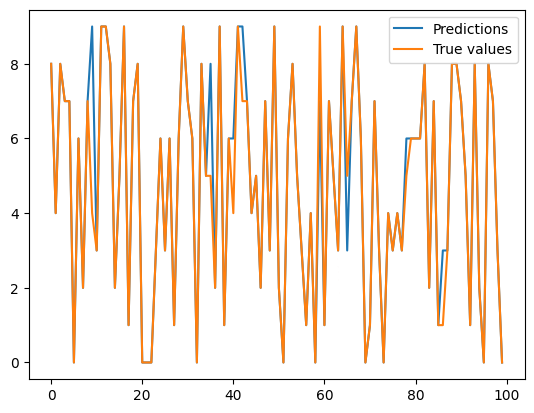

In [7]:
plt.plot(y_pred_classes[:100], label='Predictions')
plt.plot(y_test_classes[:100], label='True values')
plt.legend()

# Incorrect classifications

[8 6 9 7 6 3 8 8 7 9 0 0 6 9 0]


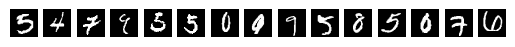

In [63]:
incorrect_predictions = X_test[y_pred_classes != y_test_classes]
incorrect_predictions_labels = y_pred_classes[y_pred_classes != y_test_classes]
print(incorrect_predictions_labels[:15]) # Predykcje

for i, incorrect in enumerate(incorrect_predictions[:15]):
    plt.subplot(1, 15, i + 1)
    plt.imshow(incorrect.reshape(28, 28), cmap='gray')
    plt.axis('off')

#   Correct classifications

[8 4 8 7 7 0 6 2 7 4 3 9 9 8 2]


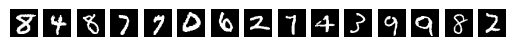

In [64]:
correct_predictions = X_test[y_pred_classes == y_test_classes][:15]
correct_predictions_labels = y_pred_classes[y_pred_classes == y_test_classes][:15]
print(correct_predictions_labels) # Predykcje

for i, correct in enumerate(correct_predictions):
    plt.subplot(1, 15, i + 1)
    plt.imshow(correct.reshape(28, 28), cmap='gray')
    plt.axis('off')

# Test of different architectures

In [68]:
for seed in [42, 123]:
    for hidden_neurons in [16, 32, 64, 128, 256, 512]:
            for activation in [Tanh(), Sigmoid()]:
                layers = [FullyConnected(784, hidden_neurons, 0.9), activation, FullyConnected(hidden_neurons, 10, 0.9)]
                accuracy = test_network(layers, seed, mse, mse_derivative)
                print(f"Seed: {seed}, hidden_neurons: {hidden_neurons}, loss_function: MSE, activation: {activation.__class__.__name__} -> Accuracy: {accuracy}")


Best loss: 0.0009683191246100153
Accuracy: 0.9232142857142858
Seed: 42, hidden_neurons: 16, loss_function: MSE, activation: Tanh -> Accuracy: 0.9232142857142858
Best loss: 0.023514903192374148
Accuracy: 0.9206428571428571
Seed: 42, hidden_neurons: 16, loss_function: MSE, activation: Sigmoid -> Accuracy: 0.9206428571428571
Best loss: 0.0013814487221948783
Accuracy: 0.9328571428571428
Seed: 42, hidden_neurons: 32, loss_function: MSE, activation: Tanh -> Accuracy: 0.9328571428571428
Best loss: 0.00024365208349711535
Accuracy: 0.9304285714285714
Seed: 42, hidden_neurons: 32, loss_function: MSE, activation: Sigmoid -> Accuracy: 0.9304285714285714
Best loss: 0.00519308237341681
Accuracy: 0.9396428571428571
Seed: 42, hidden_neurons: 64, loss_function: MSE, activation: Tanh -> Accuracy: 0.9396428571428571
Best loss: 0.00037063690306045935
Accuracy: 0.9444285714285714
Seed: 42, hidden_neurons: 64, loss_function: MSE, activation: Sigmoid -> Accuracy: 0.9444285714285714
Best loss: 0.0018523172389

# Comparison


| **Seed** | **Hidden Neurons** | **Activation** | **Loss Function** | **Accuracy**         |
|----------|---------------------|----------------|--------------------|----------------------|
| 42       | 16                  | Tanh           | MSE                | 0.9232               |
| 42       | 16                  | Sigmoid        | MSE                | 0.9206               |
| 42       | 32                  | Tanh           | MSE                | 0.9329               |
| 42       | 32                  | Sigmoid        | MSE                | 0.9304               |
| 42       | 64                  | Tanh           | MSE                | 0.9396               |
| 42       | 64                  | Sigmoid        | MSE                | 0.9444               |
| 42       | 128                 | Tanh           | MSE                | 0.9382               |
| 42       | 128                 | Sigmoid        | MSE                | 0.9501               |
| 42       | 256                 | Tanh           | MSE                | 0.9326               |
| 42       | 256                 | Sigmoid        | MSE                | 0.9529               |
| 42       | 512                 | Tanh           | MSE                | 0.7612               |
| 42       | 512                 | Sigmoid        | MSE                | 0.9521               |
| 123      | 16                  | Tanh           | MSE                | 0.9204               |
| 123      | 16                  | Sigmoid        | MSE                | 0.9202               |
| 123      | 32                  | Tanh           | MSE                | 0.9363               |
| 123      | 32                  | Sigmoid        | MSE                | 0.9330               |
| 123      | 64                  | Tanh           | MSE                | 0.9369               |
| 123      | 64                  | Sigmoid        | MSE                | 0.9415               |
| 123      | 128                 | Tanh           | MSE                | 0.9297               |
| 123      | 128                 | Sigmoid        | MSE                | 0.9504               |
| 123      | 256                 | Tanh           | MSE                | 0.9249               |
| 123      | 256                 | Sigmoid        | MSE                | 0.9556               |
| 123      | 512                 | Tanh           | MSE                | 0.8856               |
| 123      | 512                 | Sigmoid        | MSE                | 0.9566               |


#   Conclusions Regarding the Comparative Table

### The Impact of the Number of Neurons in the Hidden Layer:
In both cases (for Tanh and Sigmoid activation functions), the model's accuracy generally increases with the number of neurons in the hidden layer, reaching the best results at 256-512 neurons.
At 512 neurons, a drop in accuracy is observed for Tanh, which may indicate overfitting or challenges with efficiently training the network.

### Comparison of Activation Functions:
The Sigmoid activation function achieves higher accuracy than Tanh in most cases, especially for a larger number of neurons in the hidden layer (128, 256, 512).
For smaller numbers of neurons (16, 32, 64), the differences in accuracy between Tanh and Sigmoid are less pronounced.

### Best Result:
The best result was achieved with Sigmoid for 512 neurons in the hidden layer and seed = 123, with an accuracy of 95.66%.

### Limitations of Tanh for Larger Numbers of Neurons:
The Tanh function loses effectiveness for larger layers (e.g., 512 neurons), which may be due to issues with vanishing gradients or greater sensitivity to overfitting.

#   Summary:
Sigmoid appears to be a more effective activation function in this experiment, particularly for larger hidden layers. However, it is important to note that its performance may be limited in larger and more complex networks due to problems with vanishing gradients.